In [ ]:
import os
import cv2
import copy
import pandas as pd
from PIL import Image
import numpy as np
from matplotlib import pyplot as plt
from glob import glob
from google.colab.patches import cv2_imshow
from sklearn.metrics import jaccard_score
import random
import torch
from sklearn import svm
from sklearn.preprocessing import StandardScaler
import torchvision
import torch.nn as nn
import torch.nn.functional as F
from torch.functional import Tensor
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.datasets as datasets
from scipy.stats import kurtosis, skew
import torchvision.transforms.functional as TF
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
from torch.utils.data import Dataset, DataLoader
from torch.nn.modules.activation import ReLU
from sklearn.metrics import classification_report, balanced_accuracy_score
from sklearn.linear_model import LogisticRegression
from scipy.stats import kurtosis, skew
from sklearn.ensemble import AdaBoostClassifier
from sklearn.multiclass import OneVsRestClassifier
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import GradientBoostingClassifier
from sklearn.ensemble import StackingClassifier
from sklearn.ensemble import BaggingClassifier
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import StratifiedShuffleSplit
import seaborn as sns
import pickle
from torch.nn.modules.batchnorm import BatchNorm2d
import torch.optim as optim
from tqdm import tqdm
from google.colab import drive
from pathlib import Path
from sklearn.utils import shuffle

In [ ]:
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Directories
input_directory = '/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/Three Class Problem Preprocessed'
train_directory = input_directory+'/train' 
val_directory = input_directory+'/val'

In [ ]:
#Training set organization
train_bcc= sorted(glob(os.path.join(train_directory, "bcc", "*.jpg")))
train_mel= sorted(glob(os.path.join(train_directory, "mel", "*.jpg")))
train_scc= sorted(glob(os.path.join(train_directory, "scc", "*.jpg")))
tags_bcc_train=[]
tags_mel_train=[]
tags_scc_train=[]
tags_train=[]
images_bcc=[]
images_mel=[]
images_scc=[]
labels_bcc=[]
labels_mel=[]
labels_scc=[]

In [ ]:
#Validation set organization
train_bcc_val= sorted(glob(os.path.join(val_directory, "bcc", "*.jpg")))
train_mel_val= sorted(glob(os.path.join(val_directory, "mel", "*.jpg")))
train_scc_val= sorted(glob(os.path.join(val_directory, "scc", "*.jpg")))
tags_bcc_val=[]
tags_mel_val=[]
tags_scc_val=[]
tags_val=[]
images_bcc_val=[]
images_mel_val=[]
images_scc_val=[]
labels_bcc_val=[]
labels_mel_val=[]
labels_scc_val=[]

In [ ]:
print(len(train_bcc))
print(len(train_mel))
print(len(train_scc))
print(len(train_bcc_val))
print(len(train_mel_val))
print(len(train_scc_val))

2713
2713
2632
498
678
94


In [ ]:
#Training set DataFrame construction
for i in range(len(train_bcc)):
  tags_bcc_train.append(train_bcc[i][-12:])
  labels_bcc.append(1)
for i in range(len(train_mel)):
  tags_mel_train.append(train_mel[i][-12:])
  labels_mel.append(0)
for i in range(len(train_scc)):
  tags_scc_train.append(train_scc[i][-12:])
  labels_scc.append(2)

In [ ]:
#Validation set DataFrame construction
for i in range(len(train_bcc_val)):
  tags_bcc_val.append(train_bcc_val[i][-12:])
  labels_bcc_val.append(1)
for i in range(len(train_mel_val)):
  tags_mel_val.append(train_mel_val[i][-12:])
  labels_mel_val.append(0)
for i in range(len(train_scc_val)):
  tags_scc_val.append(train_scc_val[i][-12:])
  labels_scc_val.append(2)

In [ ]:
tags_train= tags_bcc_train + tags_mel_train + tags_scc_train
X_train= labels_bcc+labels_mel+labels_scc

In [ ]:
tags_val= tags_bcc_val + tags_mel_val+tags_scc_val
X_test= labels_bcc_val +labels_mel_val+labels_scc_val

In [ ]:
training_set= pd.DataFrame.from_dict({'Image Tag':tags_train, 'Image Route': train_bcc+train_mel+train_scc, 'Label': X_train})
valid_set= pd.DataFrame.from_dict({'Image Tag':tags_val, 'Image Route': train_bcc_val+train_mel_val+train_scc_val, 'Label': X_test})

In [ ]:
X_train_data= training_set['Image Route'].to_numpy()
y_train_data= training_set['Label'].to_numpy()
X_test_data= valid_set['Image Route'].to_numpy()
y_test_data= valid_set['Label'].to_numpy()

In [ ]:
X_train,y_train = shuffle(X_train_data,y_train_data, random_state= 42)
X_test,y_test= shuffle(X_test_data, y_test_data, random_state=42)

In [ ]:
def color_feature_extractor(images_routes):
  min_val_R=[]
  max_val_R=[]
  min_val_G=[]
  max_val_G=[]
  min_val_B=[]
  max_val_B=[]
  min_val_H=[]
  max_val_H=[]
  min_val_S=[]
  max_val_S=[]
  min_val_V=[]
  max_val_V=[]
  mean_R=[]
  mean_G=[]
  mean_B=[]
  std_R=[]
  std_G=[]
  std_B=[]
  skew_R=[]
  skew_G=[]
  skew_B=[]
  mean_H=[]
  mean_S=[]
  mean_V=[]
  std_H=[]
  std_S=[]
  std_V=[]
  skew_H=[]
  skew_S=[]
  skew_V=[]
  for i in images_routes:
    image_read=cv2.imread(i)
    #image_resized= cv2.resize(image_read,(512,512),interpolation=cv2.INTER_AREA)
    image_hsv= cv2.cvtColor(image_read, cv2.COLOR_BGR2HSV)
    min_val_R.append(image_read[:,:,0].min())
    max_val_R.append(image_read[:,:,0].max())
    min_val_G.append(image_read[:,:,1].min())
    max_val_G.append(image_read[:,:,1].max())
    min_val_B.append(image_read[:,:,2].min())
    max_val_B.append(image_read[:,:,2].max())

  
    min_val_H.append(image_hsv[:,:,0].min())
    max_val_H.append(image_hsv[:,:,0].max())
    min_val_S.append(image_hsv[:,:,1].min())
    max_val_S.append(image_hsv[:,:,1].max())
    min_val_V.append(image_hsv[:,:,2].min())
    max_val_V.append(image_hsv[:,:,2].max())

    mean_R.append(np.mean(image_read[:,:,0]))
    mean_G.append(np.mean(image_read[:,:,1]))
    mean_B.append(np.mean(image_read[:,:,2]))
    std_R.append(np.std(image_read[:,:,0]))
    std_G.append(np.std(image_read[:,:,1]))
    std_B.append(np.std(image_read[:,:,2]))

    mean_H.append(np.mean(image_hsv[:,:,0]))
    mean_S.append(np.mean(image_hsv[:,:,1]))
    mean_V.append(np.mean(image_hsv[:,:,2]))
    std_H.append(np.std(image_hsv[:,:,0]))
    std_S.append(np.std(image_hsv[:,:,1]))
    std_V.append(np.std(image_hsv[:,:,2]))
  

    skew_R.append(skew(image_read[:,:,0],axis=None))
    skew_G.append(skew(image_read[:,:,1],axis=None))
    skew_B.append(skew(image_read[:,:,2],axis=None))
  
    skew_H.append(skew(image_hsv[:,:,0],axis=None))
    skew_S.append(skew(image_hsv[:,:,1],axis=None))
    skew_V.append(skew(image_hsv[:,:,2],axis=None))
  features_dict={'MinValR': np.array(min_val_R), 'MaxValR': np.array(max_val_R), 'MinValG':np.array(min_val_G), 'MaxValG': np.array(max_val_G),
               'MaxValB': np.array(max_val_B),'MinValB': np.array(min_val_B), 'MeanR': np.array(mean_R),'MeanG': np.array(mean_G), 'meanB': np.array(mean_B), 
               'stdR': np.array(std_R), 'stdG': np.array(std_G), 'stdB': np.array(std_B), 'SkewR': skew_R, 'SkewG': skew_G, 'SkewB': skew_B,
               'MinValH': np.array(min_val_R), 'MaxValH': np.array(max_val_R), 'MinValS':np.array(min_val_G),
               'MaxValS': np.array(max_val_G), 'MinValV': np.array(min_val_B), 'MaxValV': np.array(max_val_B),'MeanH': np.array(mean_R), 
               'MeanS': np.array(mean_G), 'meanV': np.array(mean_B), 'stdH': np.array(std_R), 'stdS': np.array(std_G), 'stdV': np.array(std_B),
               'SkewH': np.array(skew_H), 'SkewS': np.array(skew_S), 'SkewV': np.array(skew_V)
               }
  features= pd.DataFrame.from_dict(features_dict) 
  return features

In [ ]:
X_train_features= color_feature_extractor(X_train)
X_test_features= color_feature_extractor(X_test)
scaler= StandardScaler().fit(X_train_features)
X_train_scaled= scaler.transform(X_train_features)
X_test_scaled= scaler.transform(X_test_features)

In [ ]:
X_train_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/Train_ColorFeatures291022.csv',index=False)
X_test_features.to_csv('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/ThreeClassProblemPreprocessed_Data/Test_ColorFeatures291022.csv',index=False)

First model: SVM

In [ ]:
model1= svm.SVC()
model1.fit(X_train_scaled,y_train)
y_pred1= model1.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred1))
print(balanced_accuracy_score(y_test,y_pred1))

              precision    recall  f1-score   support

           0       0.83      0.72      0.77       678
           1       0.68      0.64      0.66       498
           2       0.19      0.45      0.27        94

    accuracy                           0.67      1270
   macro avg       0.57      0.60      0.57      1270
weighted avg       0.73      0.67      0.69      1270

0.6020228532280129


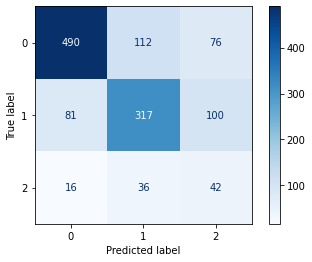

In [ ]:
cm= confusion_matrix(y_test,y_pred1,labels= model1.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model1.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Second Model: Logistic Regression

In [ ]:
model2= LogisticRegression(max_iter=2000)
model2.fit(X_train_scaled,y_train)
y_pred2= model2.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred2))
print(balanced_accuracy_score(y_test,y_pred2))

              precision    recall  f1-score   support

           0       0.75      0.69      0.72       678
           1       0.58      0.47      0.52       498
           2       0.15      0.40      0.22        94

    accuracy                           0.58      1270
   macro avg       0.50      0.52      0.49      1270
weighted avg       0.64      0.58      0.60      1270

0.5199918483952757


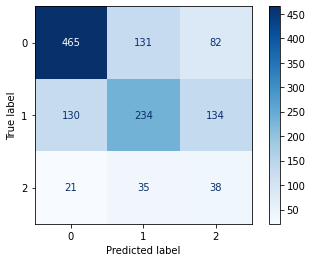

In [ ]:
cm= confusion_matrix(y_test,y_pred2,labels= model2.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model2.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Third model: Gradient Boosting

In [ ]:
model3= GradientBoostingClassifier(random_state=42)
model3.fit(X_train_scaled,y_train)
y_pred3= model3.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred3))
print(balanced_accuracy_score(y_test,y_pred3))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       678
           1       0.69      0.62      0.65       498
           2       0.17      0.41      0.25        94

    accuracy                           0.66      1270
   macro avg       0.56      0.58      0.55      1270
weighted avg       0.72      0.66      0.68      1270

0.5843771748010053


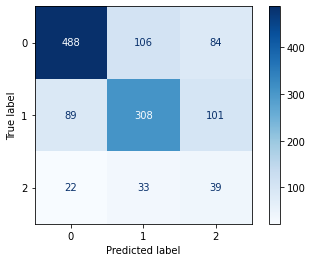

In [ ]:
cm= confusion_matrix(y_test,y_pred3,labels= model3.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model3.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fourth Model: Random Forest Classifier

In [ ]:
model4= RandomForestClassifier(random_state=42)
model4.fit(X_train_scaled,y_train)
y_pred4= model4.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred4))
print(balanced_accuracy_score(y_test,y_pred4))

              precision    recall  f1-score   support

           0       0.84      0.77      0.81       678
           1       0.73      0.72      0.72       498
           2       0.29      0.46      0.35        94

    accuracy                           0.73      1270
   macro avg       0.62      0.65      0.63      1270
weighted avg       0.75      0.73      0.74      1270

0.651558219320513


In [ ]:
#pickle.dump(model4, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_RF_model.sav', 'wb'))

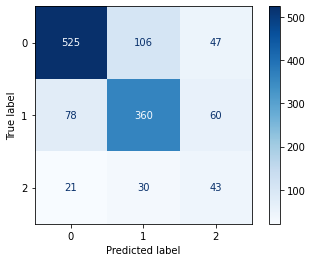

In [ ]:
cm= confusion_matrix(y_test,y_pred4,labels= model4.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model4.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Fifth model: AdaBoost classifier

In [ ]:
model5= AdaBoostClassifier(random_state=42)
model5.fit(X_train_scaled,y_train)
y_pred5= model5.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred5))
print(balanced_accuracy_score(y_test,y_pred5))

              precision    recall  f1-score   support

           0       0.77      0.70      0.73       678
           1       0.63      0.49      0.55       498
           2       0.14      0.43      0.22        94

    accuracy                           0.59      1270
   macro avg       0.52      0.54      0.50      1270
weighted avg       0.67      0.59      0.62      1270

0.5363719359960396


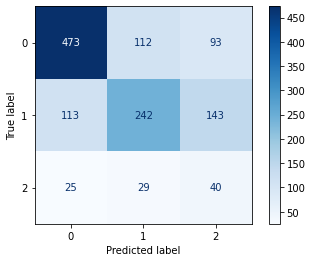

In [ ]:
cm= confusion_matrix(y_test,y_pred5,labels= model5.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model5.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Sixth Model: Decision Trees Classifier

In [ ]:
model6= DecisionTreeClassifier(random_state=42)
model6.fit(X_train_scaled,y_train)
y_pred6= model6.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred6))
print(balanced_accuracy_score(y_test,y_pred6))

              precision    recall  f1-score   support

           0       0.78      0.68      0.72       678
           1       0.64      0.60      0.62       498
           2       0.16      0.35      0.22        94

    accuracy                           0.62      1270
   macro avg       0.52      0.54      0.52      1270
weighted avg       0.68      0.62      0.64      1270

0.5429965641767471


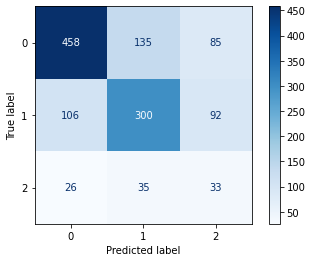

In [ ]:
cm= confusion_matrix(y_test,y_pred6,labels= model6.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model6.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Seventh model: XGBoost Classifier

In [ ]:
model7= XGBClassifier(random_state=42)
model7.fit(X_train_scaled,y_train)
y_pred7= model7.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred7))
print(balanced_accuracy_score(y_test,y_pred7))

              precision    recall  f1-score   support

           0       0.81      0.72      0.76       678
           1       0.69      0.58      0.63       498
           2       0.16      0.43      0.24        94

    accuracy                           0.64      1270
   macro avg       0.55      0.58      0.54      1270
weighted avg       0.71      0.64      0.67      1270

0.5760113194887124


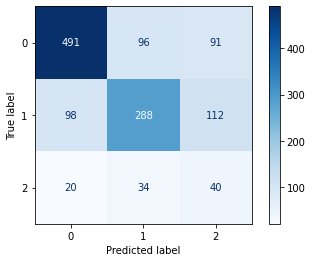

In [ ]:
cm= confusion_matrix(y_test,y_pred7,labels= model7.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model7.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eigth model: Naive Bayes Classifier

In [ ]:
model8= GaussianNB()
model8.fit(X_train_scaled,y_train)
y_pred8= model8.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred8))
print(balanced_accuracy_score(y_test,y_pred8))

              precision    recall  f1-score   support

           0       0.82      0.21      0.34       678
           1       0.39      0.51      0.44       498
           2       0.12      0.59      0.21        94

    accuracy                           0.36      1270
   macro avg       0.45      0.44      0.33      1270
weighted avg       0.60      0.36      0.37      1270

0.4371839961364317


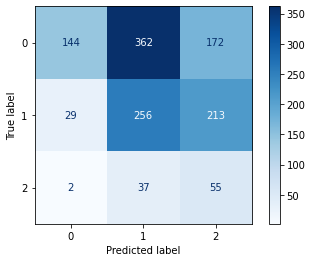

In [ ]:
cm= confusion_matrix(y_test,y_pred8,labels= model8.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model8.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Ninth Model: KNeighbors Classifier

In [ ]:
model9= KNeighborsClassifier()
model9.fit(X_train_scaled,y_train)
y_pred9= model9.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred9))
print(balanced_accuracy_score(y_test,y_pred9))

              precision    recall  f1-score   support

           0       0.83      0.71      0.77       678
           1       0.68      0.62      0.65       498
           2       0.22      0.56      0.32        94

    accuracy                           0.66      1270
   macro avg       0.58      0.63      0.58      1270
weighted avg       0.73      0.66      0.69      1270

0.6317420564073907


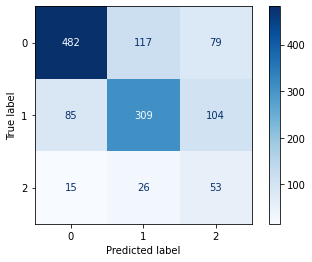

In [ ]:
cm= confusion_matrix(y_test,y_pred9,labels= model9.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model9.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Tenth Model: Bagging Classifier

In [ ]:
model10= BaggingClassifier(base_estimator=RandomForestClassifier(random_state=42),n_estimators=10,random_state=42)
model10.fit(X_train_scaled,y_train)
y_pred10= model10.predict(X_test_scaled)


In [ ]:
print(classification_report(y_test,y_pred10))
print(balanced_accuracy_score(y_test,y_pred10))

              precision    recall  f1-score   support

           0       0.83      0.77      0.80       678
           1       0.73      0.70      0.72       498
           2       0.25      0.44      0.32        94

    accuracy                           0.72      1270
   macro avg       0.60      0.64      0.61      1270
weighted avg       0.75      0.72      0.73      1270

0.6364753560151609


In [ ]:
#pickle.dump(model10, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_Bagging_model.sav', 'wb'))

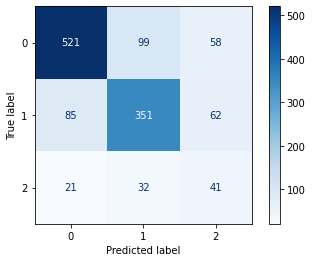

In [ ]:
cm= confusion_matrix(y_test,y_pred10,labels= model10.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model10.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()

Eleventh Model: Stacking Classifier

In [ ]:
def get_stack_model():
  level0 = list()
  level0.append(('lr', LogisticRegression(max_iter=2000,random_state=42)))
  level0.append(('knn', KNeighborsClassifier()))
  level0.append(('cart', DecisionTreeClassifier(random_state=42)))
  level0.append(('svm', svm.SVC(kernel='rbf', gamma='auto',decision_function_shape='ovr', random_state=42)))
  level0.append(('bayes', GaussianNB()))
  level0.append(('gboosting', GradientBoostingClassifier(random_state=42)))
  level0.append(('rforest', RandomForestClassifier(random_state=42)))
  level0.append(('adaboost', AdaBoostClassifier(random_state=42)))
  level1 = LogisticRegression(max_iter=2000,random_state=42)
  model = StackingClassifier(estimators=level0, final_estimator=level1, cv=5)
  return model

In [ ]:
model11=get_stack_model()
model11.fit(X_train_scaled,y_train)
y_pred11= model11.predict(X_test_scaled)

In [ ]:
print(classification_report(y_test,y_pred11))
print(balanced_accuracy_score(y_test,y_pred11))

              precision    recall  f1-score   support

           0       0.85      0.79      0.82       678
           1       0.73      0.77      0.75       498
           2       0.35      0.45      0.39        94

    accuracy                           0.76      1270
   macro avg       0.65      0.67      0.66      1270
weighted avg       0.77      0.76      0.76      1270

0.6691290360714811


In [ ]:
#pickle.dump(model11, open('/content/gdrive/MyDrive/Colab Notebooks/CAD Project/Dataset/BinaryProblem_Data/ColorFeatures_Stacking_model.sav', 'wb'))

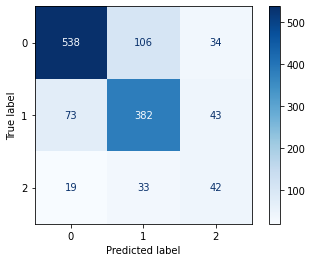

In [ ]:
cm= confusion_matrix(y_test,y_pred11,labels= model11.classes_)
disp= ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=model11.classes_)
disp= disp.plot(include_values= True, cmap=plt.cm.Blues)
plt.grid(False)
plt.show()